# TF4ces Search Engine
#### Information Retrival and Ranking Pipeline Demo

Setup system paths

In [1]:
from pathlib import Path
import sys

__WORKSPACE__ = Path.cwd().parent.parent
sys.path.append(str(__WORKSPACE__))

__WORKSPACE__

In [2]:
# Native imports
from copy import deepcopy
from IPython.core.display import HTML

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt

# User imports
from config.conf import __ALL_MODELS__
from src.TF4ces_search_engine.data.data_gathering import DataGathering
from src.main_ensemble import TF4cesSearchEnsemble
from src.utils.ensemble_strategy import EnsembleStrategy
from src.utils.evalutor import precision_K, recall_K

### Configs

In [4]:
# Model Names
TFIDF_MODEL = __ALL_MODELS__[0]
BM25_MODEL = __ALL_MODELS__[1]
MPNET_MODEL = __ALL_MODELS__[2]
ROBERTA_MODEL = __ALL_MODELS__[3]

# Dataset Configs
DATASET_NAME = 'lotte'
DATASET_CATEGORY = 'lifestyle'
SPLIT = 'test'

# Path Configs
TFIDF_MODEL_PATH = __WORKSPACE__ / "models/tfidf/lotte/lifestyle/tfidf.v0.0.1.pkl"
MPNET_EMB_PATH = __WORKSPACE__ / "dataset/embeddings_test/test_v0.0.1/all-mpnet-base-v2/lotte/lifestyle"
ROBERTA_EMB_PATH = __WORKSPACE__ / "dataset/embeddings_test/test_v0.0.1/all-roberta-large-v1/lotte/lifestyle"

In [5]:
FILTER_TOP_N = 3_000
VOTING_TOP_N = 100

FILTER_MODEL = {
    #TFIDF_MODEL: {'model_path': TFIDF_MODEL_PATH},
    BM25_MODEL: {'model_path': None},
}
VOTER_MODELS = {
    MPNET_MODEL: {'emb_path': MPNET_EMB_PATH},
    ROBERTA_MODEL: {'emb_path': ROBERTA_EMB_PATH},
}

#### Path checks

In [6]:
drive_link = "https://drive.google.com/file/d/1x-lOZMwBK5Ea9eCDE18gQCTnukZ16xQT/view?usp=share_link"

if not MPNET_EMB_PATH.exists() or not ROBERTA_EMB_PATH.exists():
    raise Exception(f"Embeddings for MPNET model is missing at this path: '{MPNET_EMB_PATH}'.\n\n Please download embeddings from here '{drive_link}'.")

### Step 1 : Data Gathering

In [7]:
SAMPLE_QUERIES_SIZE = 7    # Select N queries for testing.

data_gathering = DataGathering(dataset_name=DATASET_NAME, )
docs_obj = data_gathering.get_documents(dataset_category=DATASET_CATEGORY, dataset_split=SPLIT)
queries_obj = data_gathering.get_queries(dataset_category=DATASET_CATEGORY, dataset_split=SPLIT)
queries_obj = {id: data for id, data in queries_obj.items() if id < SAMPLE_QUERIES_SIZE}
    
del data_gathering

In [8]:
#sample doc
docs_obj[0]

{'document': 'Normal double-acting baking powder makes CO2 (thus giving a rising effect) in two ways: when it gets wet, and when it is heated. Baking soda only makes CO2 when it gets wet. From Wikipedia: The acid in a baking powder can be either fast-acting or slow-acting.[6] A fast-acting acid reacts in a wet mixture with baking soda at room temperature, and a slow-acting acid will not react until heated in an oven. Baking powders that contain both fast- and slow-acting acids are double acting; those that contain only one acid are single acting. By providing a second rise in the oven, double-acting baking powders increase the reliability of baked goods by rendering the time elapsed between mixing and baking less critical, and this is the type most widely available to consumers today.'}

In [9]:
#sample query
queries_obj[0]

{'query': 'are clear pomegranate seeds good to eat?',
 'source': 'lotte/lifestyle/test/search/0',
 'rel_doc_ids': [14700, 16020, 24746, 28366, 32117]}

### Step 2 : Init the Ensemble

In [10]:
ensemble = TF4cesSearchEnsemble(
    filter_model_dict=FILTER_MODEL,
    voter_models_dict=VOTER_MODELS,
    docs_obj=deepcopy(docs_obj),
    filter_top_n=FILTER_TOP_N,
    voting_top_n=VOTING_TOP_N,
)
ensemble.summary()

----------------------------------------------------------------------
		TF4ces Search Engine
----------------------------------------------------------------------
Filter Model	: ['bm25']
Voter Models	: ['all-mpnet-base-v2', 'all-roberta-large-v1']
Num of Docs	: 119461
Filter Top N	: 3000
Voting Top N	: 100
----------------------------------------------------------------------



### Step 3 : Load models

In [11]:
ensemble.load_filter_model(bl_train=False)
ensemble.load_voter_models()

Model [all-mpnet-base-v2] : Loaded on 'mps'
Model [all-roberta-large-v1] : Loaded on 'mps'


### Step 4 : Predictions

In [12]:
# Filter Models prediction
q_ids, filtered_rel_doc_ids = ensemble.filter_docs(queries_obj=deepcopy(queries_obj))
recall, precision = ensemble.evaluate(q_ids=q_ids, preds_doc_ids=filtered_rel_doc_ids, K=5, queries_obj=queries_obj, to_display="Filter Model")

Preprocessed data loaded from : /Users/ataago/Documents/git/TF4ces/TF4ces-search-engine/dataset/preprocessed/ensemble/bm25


Pre-Processing Queries:   0%|          | 0/7 [00:00<?, ?it/s]

Filter Model [bm25] : Retrieving top 3000 Docs for queries(7) documents(119461).
Model [BM25] : Trained on 119461 docs.
Model [BM25-Fast] : Finding most relevant Docs for given Queries...


Prediction:   0%|          | 0/7 [00:00<?, ?it/s]

-------------- Evaluation --------------
Filter Model Recall@3000 : 0.948
Filter Model Precision@3000 : 0.001
----------------------------------------
-------------- Evaluation --------------
Filter Model Recall@5 : 0.598
Filter Model Precision@5 : 0.343
----------------------------------------


In [13]:
# Voting Models prediction
ensemble.load_embeddings_if_not_present(filtered_rel_doc_ids=filtered_rel_doc_ids)
ensemble.find_most_relevant_docs(q_ids=q_ids, filtered_rel_doc_ids=filtered_rel_doc_ids, queries_obj=queries_obj)
preds = ensemble.ensemble_voting(ensemble_strategy=EnsembleStrategy.TXIOI)

Voting Model [all-mpnet-base-v2] : Loading Embeddings:   0%|          | 0/18062 [00:00<?, ?it/s]

Voting Model [all-roberta-large-v1] : Loading Embeddings:   0%|          | 0/18062 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-mpnet-base-v2]:   0%|          | 0/7 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-roberta-large-v1]:   0%|          | 0/7 [00:00<?, ?it/s]

### Step 5 : Evaluation

-------------- Evaluation --------------
Voter Models Recall@5 : 0.805
Voter Models Precision@5 : 0.564
----------------------------------------


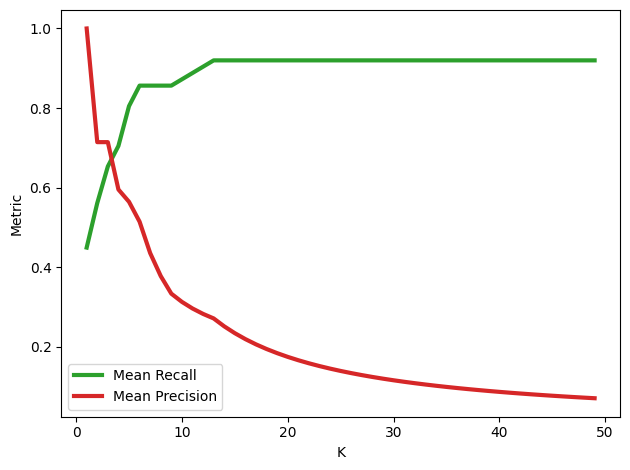

In [14]:
recall, precision = ensemble.evaluate(q_ids=q_ids, preds_doc_ids=preds, K=5, queries_obj=queries_obj, to_display="Voter Models")
ensemble.plot_eval_curve(q_ids=q_ids, queries_obj=queries_obj, preds_doc_ids=preds, max_k=50)

### 6. Individual Query Analysis

In [15]:
def get_individual_query_predictions(preds, q_ids, queries_obj, k=5):
    gold_doc_ids = [queries_obj[q_id]['rel_doc_ids'] for q_id in q_ids]
    queries = [queries_obj[q_id]['query'] for q_id in q_ids]
    
    out = list()
    for query, gold, pred in zip(queries, gold_doc_ids, preds):
        precision = precision_K(gold=gold, pred=pred, k=k)
        recall = recall_K(gold=gold, pred=pred, k=k)
        out.append([query, gold, pred[:k], round(recall, 2), round(precision, 2)])

    return pd.DataFrame(out, columns=['Query', 'Gold (doc_ids)', 'Pred (doc_ids)', 'Recall', 'Precision'], index=q_ids)

In [16]:
df = get_individual_query_predictions(preds=preds, q_ids=q_ids, queries_obj=queries_obj, k=5)
display(HTML(df.to_html()))

,Query,Gold (doc_ids),Pred (doc_ids),Recall,Precision
0,are clear pomegranate seeds good to eat?,"[14700, 16020, 24746, 28366, 32117]","[32117, 16020, 14700, 9538, 24746]",0.80,0.80
1,do you need to refrigerate homemade vinaigrette?,"[8028, 8037, 19460, 29505]","[8028, 19460, 8028, 30833, 8037]",0.75,0.75
2,how many teaspoons of juice in half a lemon?,"[5365, 15766, 17926, 18090]","[5365, 13342, 5365, 18090, 15766]",0.75,0.75
3,what is the difference between old fashioned oats and quick 1 minute oats?,[2294],"[2294, 26421, 3171, 30605, 17169]",1.00,0.20
4,what is a difference between oven and microwave?,[29835],"[29835, 4177, 29835, 47634, 47632]",1.00,0.25
5,what is the difference between risotto rice and paella rice?,"[12373, 12374, 18795]","[12373, 18795, 12374, 42917, 6910]",1.00,0.60
6,how to cook spaghetti squash not watery?,"[7722, 7726, 7764, 13425, 13426, 15520, 30185, 32228, 32922]","[7722, 47442, 15520, 13425, 29135]",0.33,0.60


### 7. User Query input

In [17]:
def get_prediction_dfs(preds, user_queries_obj, k=5):
    pred_dfs = dict()
    for (q_id, q_data), pred_doc_ids in zip(user_queries_obj.items(), preds):
        pred_dfs[q_id] = pd.DataFrame(
            map(lambda doc_id: docs_obj[doc_id]['document'], pred_doc_ids[:k]),
            columns=[q_data['query']],
            index=pred_doc_ids[:k]
        )
    return pred_dfs

def query_it(query, top=5):
    
    # Generate query obj
    user_queries = [query]
    user_queries_obj = {q_id: {'query': query, 'rel_doc_ids': list()} for q_id, query in enumerate(user_queries)}
    
    # Filter docs using filter model
    q_ids, filtered_rel_doc_ids = ensemble.filter_docs(queries_obj=deepcopy(user_queries_obj), bl_eval=False)
    
    # Ensemble with Voter predictions
    #ensemble.load_embeddings(filtered_rel_doc_ids=filtered_rel_doc_ids)
    ensemble.load_embeddings_if_not_present(filtered_rel_doc_ids=filtered_rel_doc_ids)
    ensemble.find_most_relevant_docs(q_ids=q_ids, filtered_rel_doc_ids=filtered_rel_doc_ids, queries_obj=user_queries_obj)
    preds = ensemble.ensemble_voting(ensemble_strategy=EnsembleStrategy.TXIOI)
    
    # Generate data frame of docs
    pred_dfs = get_prediction_dfs(preds=preds, user_queries_obj=user_queries_obj, k=top)
    display(HTML(pred_dfs[0].to_html()))


In [18]:
query_it("what is the difference between dark chocolate and bittersweet chocolate?", top=3)

Preprocessed data loaded from : /Users/ataago/Documents/git/TF4ces/TF4ces-search-engine/dataset/preprocessed/ensemble/bm25


Pre-Processing Queries:   0%|          | 0/1 [00:00<?, ?it/s]

Filter Model [bm25] : Retrieving top 3000 Docs for queries(1) documents(119461).
Model [BM25] : Trained on 119461 docs.
Model [BM25-Fast] : Finding most relevant Docs for given Queries...


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Voting Model [all-mpnet-base-v2] : Loading Embeddings:   0%|          | 0/1787 [00:00<?, ?it/s]

Voting Model [all-roberta-large-v1] : Loading Embeddings:   0%|          | 0/1787 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-mpnet-base-v2]:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-roberta-large-v1]:   0%|          | 0/1 [00:00<?, ?it/s]

,what is the difference between dark chocolate and bittersweet chocolate?
24746,"Got pomegranate with pale pink/white seed. I was surprised when i first opened it because i have been always getting the dark red seed varity. I thought i got a bad fruit. After I taste it, those pale pink/white seed taste sweeter and it is less tart than the drak red varity. It is also more juicy. I LOVED it!!"
37727,"The only thing of note I've ever taken from commercially available dried fruit is that sulphur dioxide is almost universally used as a preservative. Some people are sensitive to this. There are various limits on how much you are allowed to use, but no outright bans in preservation. You can buy fruit that has no added sulphur dioxide. This tends to be in the organic section and therefore tends to be that much more expensive. But remember that dried fruit is essentially concentrated sugar. There's a reason young children like it. So for the same reason you don't let them eat as much chocolate as they'd probably like, I'd encourage some moderation. Perhaps try some fresh fruit in your baking. In relation to calcium, it's sulphur dioxide that makes ""acid rain"", which leaches away limestone and other calcium carbonate rock sources. I can't find anything reputable that makes a link here but there's a big pile of ""health"" blogs out there that seem to think ""because acid rain"" is an answer enough, who has time to do the science? I'm certainly not saying you should avoid sulphites (unless you medically need to) but they can be avoided. Dried prunes are apparently well recognised for their benefits to bone health."
21138,"I suspect the textural change you experienced is analogous to the seizing of chocolate (which is also a ground, fatty seed--in that aspect similar to a sunflower seed). Sunflower seeds are fairly dry. The consist mostly of fat, and starches, and protein. When you add a small amount of water (from the mashed up banana), the starches in the sunflower hydrate and absorb the water, making it thick and giving the textural transformation you experienced. If this hypothesis is correct, adding enough additional water to fully dissolve and suspend the starches will give you a smooth fluid, or paste again. As to the taste perception, that I cannot comment on."


In [19]:
query_it("is baking powder the same as baking flour?", top=3)

Preprocessed data loaded from : /Users/ataago/Documents/git/TF4ces/TF4ces-search-engine/dataset/preprocessed/ensemble/bm25


Pre-Processing Queries:   0%|          | 0/1 [00:00<?, ?it/s]

Filter Model [bm25] : Retrieving top 3000 Docs for queries(1) documents(119461).
Model [BM25] : Trained on 119461 docs.
Model [BM25-Fast] : Finding most relevant Docs for given Queries...


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Voting Model [all-mpnet-base-v2] : Loading Embeddings:   0%|          | 0/1919 [00:00<?, ?it/s]

Voting Model [all-roberta-large-v1] : Loading Embeddings:   0%|          | 0/1919 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-mpnet-base-v2]:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-roberta-large-v1]:   0%|          | 0/1 [00:00<?, ?it/s]

,is baking powder the same as baking flour?
35203,"Whether or not ""you"" specifically choose to de-hull pumpkin seeds before grinding them to make flour, pumpkin seed shells are certainly edible, both raw and roasted. The first source you name certainly seems to be referring to pre-shelled pumpkin seeds, not just because they mention it being green, but also because their image of finished pumpkin seed flour is comparable in color to the ground pumpkin seed flour I've made from just the kernels. Note 1: It is green…so you might not want to use it for almond flour vanilla cake (or other such light colored dishes). I am sure even if you used sucanat for a sweetener in a baked good it would be enough to cover up the light green color. Hulling pumpkin seeds is a chore without a hulling centrifuge, but the easiest way I've found is to roast them, chop them in a food chopper, and then separate the kernel bits from the hull bits using a bowl of water (the kernels will sink, the hulls will float). While pumpkin seed hulls won't damage your GI tract the way other nut hulls will, they're mostly fiber and some carbs, with a little boost of zinc in the attached endosperm. Thus, the relative difference in protein/fat/simple-carb/fiber levels will affect the texture and nutrition of your final flour product, so the choice of whether to hull or not depends primarily on whether you want this to be more of a protein powder or more of a baking flour."
33083,"Powdered sugar doesn't seem like a great thickener to me. It takes a lot to thicken a small amount of liquid, and as you've noticed, that means it'll end up pretty sweet. As an example, you can make a glaze (e.g. for cinnamon rolls) with a cup of powdered sugar and only a few tablespoons of liquid. Generally, people thicken things using starch, most commonly flour and cornstarch, but also things like potato starch, arrowroot powder, tapioca/cassava starch. They're stronger thickeners, and don't really have much flavor of their own. So I'd use as much sugar as you want to balance the pomegranate's sourness, and then use starch to thicken. You probably won't need extra sour at that point, but if you want it, you could certainly add something like lemon juice or vinegar."
3908,"This can commonly happen with carrots, blueberries and sunflower seeds. It's due to having a batter that's too alkaline or not having the baking soda evenly mixed throughout the batter. Anthocyanin and other food color pigments are sensitive to pH level. When they are in contact with more alkaline surroundings they will change color. While maybe a bit unappetizing in color, it's still safe to eat. Either make sure your baking soda is completely mixed with the dry ingredients and evenly moistened, or try decreasing the soda slightly."


In [20]:
query_it("How do I flip an egg easily when preparing it?", top=3)

Preprocessed data loaded from : /Users/ataago/Documents/git/TF4ces/TF4ces-search-engine/dataset/preprocessed/ensemble/bm25


Pre-Processing Queries:   0%|          | 0/1 [00:00<?, ?it/s]

Filter Model [bm25] : Retrieving top 3000 Docs for queries(1) documents(119461).
Model [BM25] : Trained on 119461 docs.
Model [BM25-Fast] : Finding most relevant Docs for given Queries...


Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

Voting Model [all-mpnet-base-v2] : Loading Embeddings:   0%|          | 0/1947 [00:00<?, ?it/s]

Voting Model [all-roberta-large-v1] : Loading Embeddings:   0%|          | 0/1947 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-mpnet-base-v2]:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-roberta-large-v1]:   0%|          | 0/1 [00:00<?, ?it/s]

,How do I flip an egg easily when preparing it?
35944,"At between 1000-3500 on the Scoville scale poblanos are certainly safe to use raw. Cleaning(removing the insides) would help to mellow them. Peeling them would probably be good, and that is challenging with a raw poblano. Torching them (per @SomeInterwebDev) to make them peel easily is a good idea, or just roast them..."
32334,"Pumpkin seeds roasted with a little of salty water is a great (and commonly sold and home made in México) snack. They are also used along with sunflower seeds in preparing some hot sauces and Mole (the hard way). Seeds of Cantaloupe (melon) and Watermelon can be blendend along with their edible parts to strengthen flavor and keep freshness when preparing fruit flavored/fresh water (""Agua fresca""). When watermelon seeds are really small, you can eat and chew them along with the fruit: they are usually sweet."
35944,"At between 1000-3500 on the Scoville scale poblanos are certainly safe to use raw. Cleaning(removing the insides) would help to mellow them. Peeling them would probably be good, and that is challenging with a raw poblano. Torching them (per @SomeInterwebDev) to make them peel easily is a good idea, or just roast them..."


## Thank you

Group 2 : **The Four Aces : TF4ces**

Members : 
	
    - Ayushi Choudhury
	- Edmund Lepre
	- Arvind Jadhav
    - Mohammed Ataaur Rahaman
    

Project : github.com/TF4ces/TF4ces-search-engine